# Generating images with DDPMs: A JAX Implementation

Denoise Diffusion Probabilistic Models (DDPMs) are generative models based on the idea of reversing a noising process. The idea is fairly simple: Given a dataset, make it more and more noisy with a deterministic process. Then, learn a model that can undo this process.

DDPM-based models have recently drawn a lot of attention due to their high-quality samples. In this notebook, I re-implement the first and most fundamental paper to be familiar with when dealing with DDPMs: <i>Denoising Diffusion Probabilistic Models</i> (https://arxiv.org/pdf/2006.11239.pdf) by Ho et. al.

**Modified from:** (https://github.com/BrianPulfer/PapersReimplementations/tree/master/ddpm) 

# Installs

In [32]:
# !pip3 install --upgrade pip
# !pip3 install imageio numpy tqdm matplotlib
# !pip3 install torch torchvision torchaudio

In [33]:
# ! pip3 install equinox einops

# Imports and Definitions

In [34]:
# Import of libraries
import random
import jax
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import grad, jit, vmap
import equinox as eqx
import optax
from functools import partial

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

In [35]:
# ! pip install -U "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

## Execution options

Here's a few options you should set:

 - `no_train` specifies whether you want to skip the training loop and just use a pre-trained model. If you haven't trained a model already using this notebook, keep this as `False`. If you want to use a pre-trained model, load it in the colab filesystem.

- `fashion` specifies whether you want to use the Fashion-MNIST dataset (`True`) or not and use the MNIST dataset instead (`False`).

- `batch_size`, `n_epochs` and `lr` are your typical training hyper-parameters. Notice that `lr=0.001` is the hyper-parameter used by the authors.


In [36]:
no_train = False
fashion = False #True
batch_size = 128
n_epochs = 25 # 20
lr = 0.001

In [37]:
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"

# Utility functions

Following are two utility functions: `show_images` allows to display images in a square-like pattern with a custom title, while `show_fist_batch` simply shows the images in the first batch of a DataLoader object.

In [38]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [39]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

## Loading data
We will use the MNIST (or FashionMNIST) dataset and try to generate some new samples out of (nowhere, but starting from some) random gaussian noise. **NOTE**: It is important to normalize images in range `[-1,1]` and not `[0,1]` as one might usually do. This is because the DDPM network predicts normally distributed noises throughout the denoising process.

In [40]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

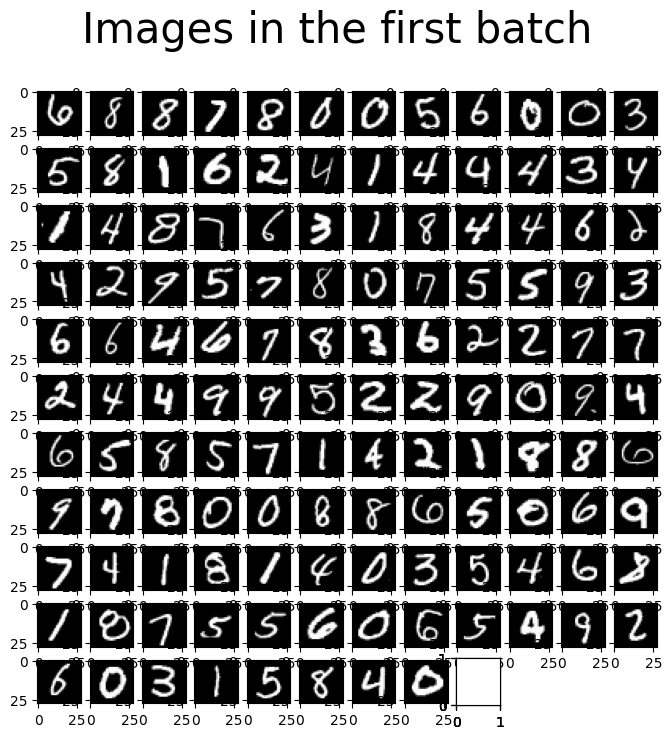

In [41]:
# Optionally, show a batch of regular images
show_first_batch(loader)

## Getting device

If you are running this codebook from Google Colab, make sure you are using a GPU runtime. For non-pro users, typically a *Tesla T4* GPU is provided.

In [42]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	NVIDIA TITAN RTX


In [43]:
def jax_has_gpu():
    try:
        _ = jax.device_put(jax.numpy.ones(1), device=jax.devices('gpu')[0])
        return True
    except:
        return False
    
jax_has_gpu()

True

In [44]:
jax.local_devices()

[cuda(id=0)]

# Defining the DDPM module

We now proceed and define a DDPM PyTorch module. Since in principle the DDPM scheme is independent of the model architecture used in each denoising step, we define a high-level model that is constructed using a `network` parameter, as well as:

- `n_steps`: number of diffusion steps $T$;
- `min_beta`: value of the first $\beta_t$ ($\beta_1$);
- `max_beta`: value of the last  $\beta_t$ ($\beta_T$);
- `device`: device onto which the model is run;
- `image_chw`: tuple contining dimensionality of images.

The `forward` process of DDPMs benefits from a nice property: We don't actually need to slowly add noise step-by-step, but we can directly skip to whathever step $t$ we want using coefficients $\alpha_bar$.

For the `backward` method instead, we simply let the network do the job.

Note that in this implementation, $t$ is assumed to be a `(N, 1)` tensor, where `N` is the number of images in tensor `x`. We thus support different time-steps for multiple images.

In [45]:
# DDPM class
class MyDDPM_Jax(eqx.Module):
    n_steps: int
    # network: eqx.Module
    image_chw: tuple
    alphas: jnp.ndarray
    alpha_bars: jnp.ndarray
    betas: jnp.ndarray

    def __init__(self, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM_Jax, self).__init__()
        self.n_steps = n_steps
        # self.device = device
        self.image_chw = image_chw
        # self.network = network
        self.betas = jnp.linspace(min_beta, max_beta, n_steps) # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = jnp.array([jnp.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))])

    def __call__(self, x0, t, eta=None):
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]
        # print('a_bar', a_bar)
        if eta is None:
            eta = np.random.randn(n, c, h, w)

        noisy = jnp.sqrt(a_bar).reshape(n, 1, 1, 1) * x0 + jnp.sqrt((1 - a_bar)).reshape(n, 1, 1, 1) * eta
        return noisy

    # @partial(jax.vmap, in_axes=(None, None, 0))
    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = np.random.randn(n, c, h, w)

        # print(a_bar.shape, x0.shape, eta.shape)
        noisy = jnp.sqrt(a_bar).reshape(n, 1, 1, 1) * x0 + jnp.sqrt((1 - a_bar)).reshape(n, 1, 1, 1) * eta
        return noisy

    # def backward(self, x, t):
    #     # Run each image through the network for each timestep t in the vector t.
    #     # The network returns its estimation of the noise that was added.
    #     return self.network(x, t)

## Visualizing forward and backward

Now that we have defined the high-level functioning of a DDPM model, we can already define some related utility functions.

In particular, we will be showing the forward process (which is independent of the denoising network) with the `show_forward` method.

We run the backward pass and generate new images with the `generate_new_images` method, but this time we will put more effort into the function and also make it such that a GIF image is created. Notice that in the paper (https://arxiv.org/pdf/2006.11239.pdf) by Ho et. al., two options are considered for $\sigma_t^2$:

- $\sigma_t^2$ = $\beta_t$
- $\sigma_t^2$ = $\frac{1 - \bar{\alpha_{t-1}}}{1 - \bar{\alpha_{t}}} \beta_t$

In this implementation, they are both a few line-comments away. However, the two terms are rougly always the same and little difference is noticeable. By default, I choose the first option out of simplicity.

In [46]:
def show_forward(ddpm, loader):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0].numpy()
        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            h = np.array([int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))])
            h = h.reshape(1,-1)
            p = ddpm(imgs, h)
            show_images(p,
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [47]:
# for batch in loader:
#     imgs = batch[0].numpy()
#     # show_images(imgs, "Original images")
#     print(imgs[1,:,:,0])

#     for percent in [0.9]:
#         h = np.array([int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))])
#         h = h.reshape(1,-1)
#         p = ddpm(imgs, h)
#         print(p[1,:,:,0])
#         show_images(p,
#             f"DDPM Noisy images {int(percent * 100)}%"
#         )
#     break

In [48]:
# imgs = np.zeros((128, 1, 28, 28))
# h = np.array([int(0.9 * ddpm.n_steps) - 1 for _ in range(len(imgs))])
# h = h.reshape(1,-1)
# print(h)
# t = ddpm(imgs, h)
# show_images(t)

In [49]:
def generate_new_images(ddpm, unet, n_samples=16, frames_per_gif=100, gif_name="sampling.gif", c=1, h=28, w=28):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    # Starting from random noise
    x = np.random.randn(n_samples, c, h, w)

    for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
        # Estimating noise to be removed
        time_tensor = (np.ones((n_samples, 1)) * t).astype(int)
        # print(time_tensor)
        eta_theta = unet(x, time_tensor)
        # print('eta_theta', eta_theta)
        alpha_t = ddpm.alphas[t]
        alpha_t_bar = ddpm.alpha_bars[t]

        # Partially denoising the image
        x = (1 / np.sqrt(alpha_t)) * (x - (1 - alpha_t) / np.sqrt((1 - alpha_t_bar)) * eta_theta)
        x = np.array(x)
        # print('x',x)
        # print(x.shape)
        if t > 0:
            z = np.random.randn(n_samples, c, h, w)

            # Option 1: sigma_t squared = beta_t
            beta_t = ddpm.betas[t]
            sigma_t = np.sqrt(beta_t)

            # Option 2: sigma_t squared = beta_tilda_t
            # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
            # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
            # sigma_t = beta_tilda_t.sqrt()

            # Adding some more noise like in Langevin Dynamics fashion
            x = x + sigma_t * z
            

        # Adding frames to the GIF
        if idx in frame_idxs or t == 0:
            # Putting digits in range [0, 255]
            normalized = np.copy(x)
            # print(type(normalized))
            for i in range(len(normalized)):
                normalized[i] -= np.min(normalized[i])
                normalized[i] *= 255 / np.max(normalized[i])
            # print(normalized)
            # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
            frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
            # print(frame)
            frame = frame.astype(np.uint8)

            # Rendering frame
            frames.append(frame)
    # print(len(frames))
    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            rgb_frame = np.repeat(frame, 3, axis=2)
            writer.append_data(rgb_frame)

            # Showing the last frame for a longer time
            if idx == len(frames) - 1:
                last_rgb_frame = np.repeat(frames[-1], 3, axis=2)
                for _ in range(frames_per_gif // 3):
                    writer.append_data(last_rgb_frame)
    return x

In [50]:
x = np.random.randn(4, 1, 28, 28)

In [51]:
# print("Generating new images")
# generated = generate_new_images(ddpm,
#         best_model,
#         n_samples=4,
#         gif_name="fashion.gif" if fashion else "mnist.gif"
#     )
# show_images(generated, "Final result")

In [52]:
# generated = np.array([generated])

# generated.shape

# UNet architecture

Okay great! All that concerns DDPM is down on the table already. So now we simply define an architecture that will be responsible of denoising the we should be good to go... Not so fast! While in principle that's true, we have to be careful to conditioning our model with the temporal information.

Remember that the only term of the loss function that we really care about is $||\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon, t)||^2$, where $\epsilon$ is some random noise and $\epsilon_\theta$ is the model's prediction of the noise. Now, $\epsilon_\theta$ is a function of both $x$ and $t$ and we don't want to have a distinct model for each denoising step (thousands of independent models), but instead we want to use a single model that takes as input the image $x$ and the scalar value indicating the timestep $t$.

To do so, in practice we use a sinusoidal embedding (function `sinusoidal_embedding`) that maps each time-step to a `time_emb_dim` dimension. These time embeddings are further mapped with some time-embedding MLPs (function `_make_te`) and added to tensors through the network in a channel-wise manner.

**NOTE:** This UNet architecture is purely arbitrary and was desined to work with 28x28 spatial resolution images.

In [53]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = np.zeros((n, d))
    wk = np.array([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = np.arange(n).reshape((n, 1))
    embedding[:,::2] = np.sin(t * wk[:,::2])
    embedding[:,1::2] = np.cos(t * wk[:,::2])

    return embedding

In [54]:
class MyBlock(eqx.Module):
    ln: eqx.nn.LayerNorm
    conv1: eqx.nn.Conv2d
    conv2: eqx.nn.Conv2d
    activation: jax.nn.silu
    normalize: bool
    
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()

        key = jax.random.PRNGKey(0)

        self.ln = eqx.nn.LayerNorm(shape)
        self.conv1 = eqx.nn.Conv2d(in_c, out_c, kernel_size, stride, padding, key=key)
        self.conv2 = eqx.nn.Conv2d(out_c, out_c, kernel_size, stride, padding, key=key)
        self.activation = jax.nn.silu if activation is None else activation
        self.normalize = normalize

    def __call__(self, x, **kwargs):
        return self.forward(x)  

    # @partial(jax.vmap, in_axes=(None, 0))
    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [55]:
class MyUNet_Jax(eqx.Module):
    time_embed: eqx.nn.Embedding

    te1: eqx.nn.Sequential
    te2: eqx.nn.Sequential
    te3: eqx.nn.Sequential
    te_mid: eqx.nn.Sequential
    te4: eqx.nn.Sequential
    te5: eqx.nn.Sequential
    te_out: eqx.nn.Sequential

    b1: eqx.nn.Sequential
    b2: eqx.nn.Sequential
    b_mid: eqx.nn.Sequential
    b3: eqx.nn.Sequential
    b4: eqx.nn.Sequential
    b5: eqx.nn.Sequential
    b_out: eqx.nn.Sequential

    down1: eqx.nn.Conv2d
    down2: eqx.nn.Conv2d
    down3: eqx.nn.Sequential

    up1: eqx.nn.Sequential
    up2: eqx.nn.ConvTranspose2d
    up3: eqx.nn.ConvTranspose2d

    conv_out: eqx.nn.Conv2d

    
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet_Jax, self).__init__()

        key = jax.random.PRNGKey(0)

        # Sinusoidal embedding
        self.time_embed = eqx.nn.Embedding(weight=sinusoidal_embedding(n_steps, time_emb_dim), key = key)
        # self.time_embed = eqx.nn.Embedding(num_embeddings = n_steps, embedding_size = time_emb_dim, weight=sinusoidal_embedding(n_steps, time_emb_dim))
        # self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        # self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        # self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = eqx.nn.Sequential([
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)]
        )
        self.down1 = eqx.nn.Conv2d(10, 10, 4, 2, 1, key=key)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = eqx.nn.Sequential([
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)]
        )
        self.down2 = eqx.nn.Conv2d(20, 20, 4, 2, 1, key=key)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = eqx.nn.Sequential([
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)]
        )
        self.down3 = eqx.nn.Sequential([
            eqx.nn.Conv2d(in_channels = 40, out_channels= 40, kernel_size= 2, stride=1, key=key),
            # eqx.nn.Conv2d(40, 40, 2, 1, key=key),
            eqx.nn.Lambda(jax.nn.silu),
            eqx.nn.Conv2d(in_channels = 40, out_channels= 40, kernel_size= 4, stride=2, padding=1, key=key)]
            # eqx.nn.Conv2d(40, 40, 4, 2, 1, key=key)]
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = eqx.nn.Sequential([
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)]
        )

        # Second half
        self.up1 = eqx.nn.Sequential([
            eqx.nn.ConvTranspose2d(in_channels = 40, out_channels= 40, kernel_size= 4, stride=2, padding=1, key=key),
            eqx.nn.Lambda(jax.nn.silu),
            # eqx.nn.ConvTranspose2d(40, 40, 2, 1, key=key)
            eqx.nn.ConvTranspose2d(in_channels = 40, out_channels= 40, kernel_size= 2, stride=1, key=key)
            ]
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = eqx.nn.Sequential([
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)]
        )

        # self.up2 = eqx.nn.ConvTranspose2d(20, 20, 4, 2, 1, key=key)
        self.up2 = eqx.nn.ConvTranspose2d(in_channels = 20, out_channels= 20, kernel_size= 4, stride=2, padding=1, key=key)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = eqx.nn.Sequential([
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)]
        )

        self.up3 = eqx.nn.ConvTranspose2d(in_channels = 10, out_channels= 10, kernel_size= 4, stride=2, padding=1, key=key)
        # eqx.nn.ConvTranspose2d(10, 10, 4, 2, 1, key=key)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = eqx.nn.Sequential([
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)]
        )

        self.conv_out = eqx.nn.Conv2d(10, 1, 3, 1, 1, key=key)

    @partial(jax.vmap, in_axes=(None, 0, None))
    def __call__(self, x, t):
        # return self.forward(x, t)
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        n = len(x)
        t = t[0][0]
        # print('t', t)
        t = self.time_embed(t)#.numpy()
        # print('t', t)

        out1 = self.b1(x + self.te1(t).reshape(-1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(-1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(-1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(-1, 1, 1))  # (N, 40, 3, 3)

        out4 = jnp.concatenate((out3, self.up1(out_mid)), axis=0)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(-1, 1, 1))  # (N, 20, 7, 7)

        out5 = jnp.concatenate((out2, self.up2(out4)), axis=0)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(-1, 1, 1))  # (N, 10, 14, 14)

        out = jnp.concatenate((out1, self.up3(out5)), axis=0)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(-1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    @partial(jax.vmap, in_axes=(None, 0, None))
    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        n = len(x)

        t = t[0]

        t = self.time_embed(t)
        
        out1 = self.b1(x + self.te1(t).reshape(-1, 1, 1))  # (N, 10, 28, 28)
        # print('out 1', out1.shape)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(-1, 1, 1))  # (N, 20, 14, 14)
        # print('out 2', out2.shape)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(-1, 1, 1))  # (N, 40, 7, 7)
        # print('out 3',(out3.shape))

        # print('down3(out 3)', self.down3(out3).shape)
        # print('te_mid(t)', self.te_mid(t).shape)

        # print('te_mid(t) reshape', self.te_mid(t).reshape(-1, 1, 1).shape)
        # print('sum', (self.down3(out3) + self.te_mid(t).reshape(-1, 1, 1)).shape)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(-1, 1, 1))  # (N, 40, 3, 3)
        # print('out_mid', out_mid.shape)

        # print('up1.out_mid', self.up1(out_mid).shape)

        out4 = jnp.concatenate((out3, self.up1(out_mid)), axis=0)  # (N, 80, 7, 7)
        # print('out_4', out4.shape)
        # print('te_4(t)', self.te4(t).shape)
        out4 = self.b4(out4 + self.te4(t).reshape(-1, 1, 1))  # (N, 20, 7, 7)

        # print('out_2', out2.shape)
        # print('up2.out4', self.up2(out4).shape)
        out5 = jnp.concatenate((out2, self.up2(out4)), axis=0)  # (N, 40, 14, 14)
        # print('out_5', out5.shape)
        # print('te_5(t)', self.te5(t).shape)
        out5 = self.b5(out5 + self.te5(t).reshape(-1, 1, 1))  # (N, 10, 14, 14)

        # print('out_1', out1.shape)
        # print('up3.out5', self.up3(out5).shape)
        out = jnp.concatenate((out1, self.up3(out5)), axis=0)  # (N, 20, 28, 28)
        # print('out', out.shape)
        out = self.b_out(out + self.te_out(t).reshape(-1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        key = jax.random.PRNGKey(0)
        return eqx.nn.Sequential([
            eqx.nn.Linear(dim_in, dim_out, key=key),
            eqx.nn.Lambda(jax.nn.silu),
            eqx.nn.Linear(dim_out, dim_out, key=key)]
        )

In [56]:
# key = jax.random.PRNGKey(0)

# # Sinusoidal embedding
# time_embed = eqx.nn.Embedding(weight=sinusoidal_embedding(n=1000, d=100), key = key)

# # @partial(jax.vmap, in_axes=(0))
# def embed(x):
#     print(x)
#     x = x[0]
#     return time_embed(x)

# t = np.random.choice(100, (2))

# embed(t)

# Instantiating the model

We are finally done! Now we simply need to instantiate a model, optionally play a bit with it (show forward and backward processes) and write the usual code that defines a training loop for our model. When the model will be done training, we will test it's generative capabilities.

In [57]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM_Jax(n_steps=n_steps, min_beta=min_beta, max_beta=max_beta)
unet = MyUNet_Jax(n_steps)

In [58]:
ddpm

MyDDPM_Jax(
  n_steps=1000,
  image_chw=(1, 28, 28),
  alphas=f32[1000],
  alpha_bars=f32[1000],
  betas=f32[1000]
)

In [59]:
unet

MyUNet_Jax(
  time_embed=Embedding(
    num_embeddings=1000,
    embedding_size=100,
    weight=f64[1000,100](numpy)
  ),
  te1=Sequential(
    layers=(
      Linear(
        weight=f32[1,100],
        bias=f32[1],
        in_features=100,
        out_features=1,
        use_bias=True
      ),
      Lambda(fn=<wrapped function silu>),
      Linear(
        weight=f32[1,1],
        bias=f32[1],
        in_features=1,
        out_features=1,
        use_bias=True
      )
    )
  ),
  te2=Sequential(
    layers=(
      Linear(
        weight=f32[10,100],
        bias=f32[10],
        in_features=100,
        out_features=10,
        use_bias=True
      ),
      Lambda(fn=<wrapped function silu>),
      Linear(
        weight=f32[10,10],
        bias=f32[10],
        in_features=10,
        out_features=10,
        use_bias=True
      )
    )
  ),
  te3=Sequential(
    layers=(
      Linear(
        weight=f32[20,100],
        bias=f32[20],
        in_features=100,
        out_features=20,

# Optional visualizations

In [60]:
# Optionally, load a pre-trained model that will be further trained
# ddpm.load_state_dict(torch.load(store_path, map_location=device))

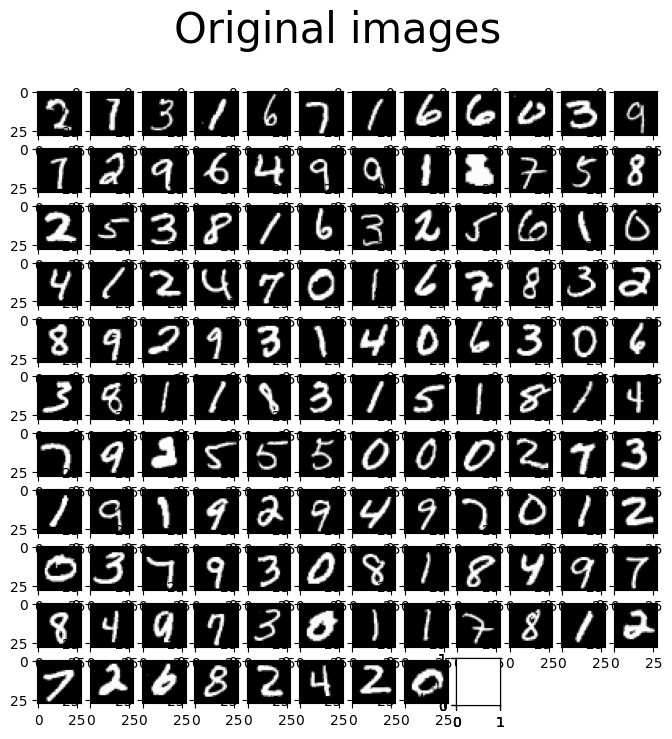

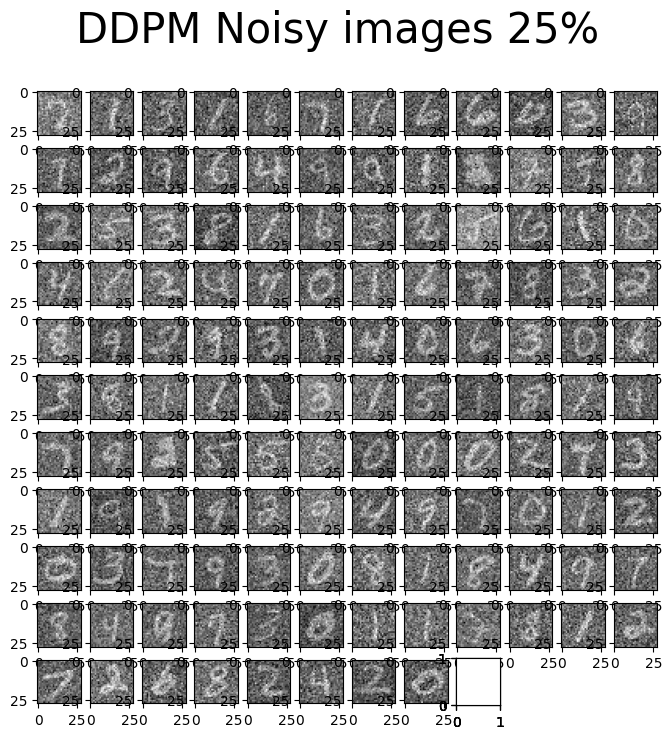

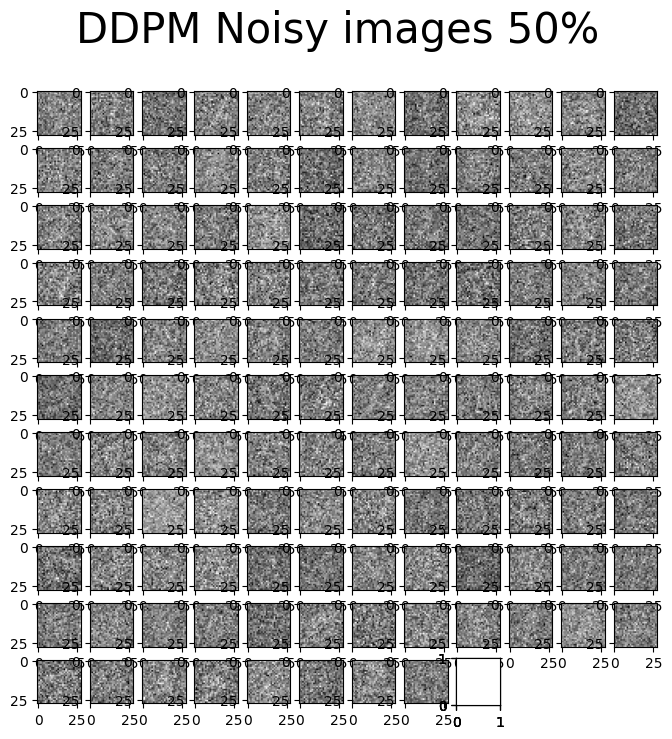

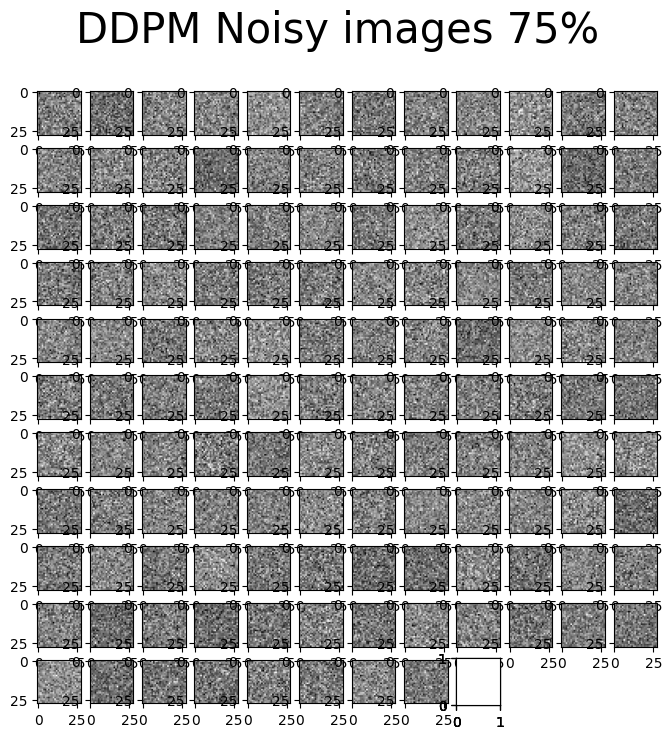

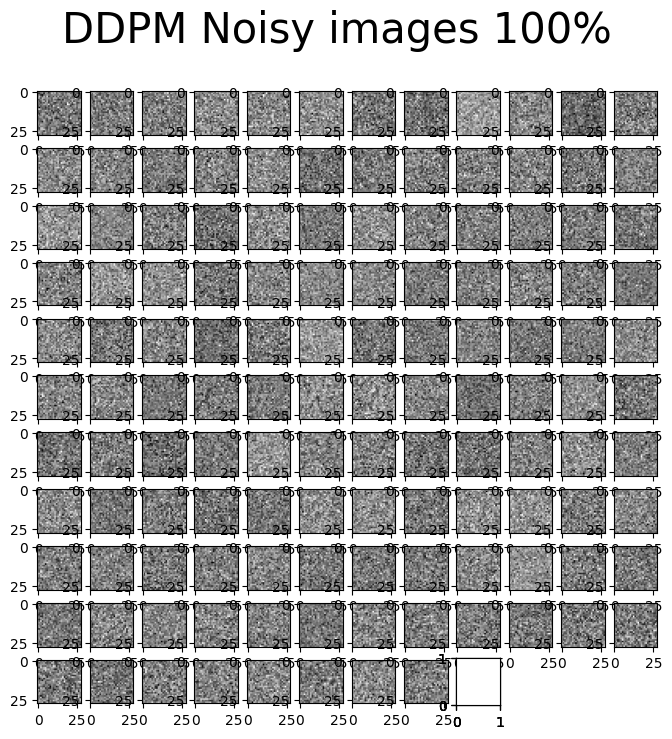

In [61]:
# Optionally, show the diffusion (forward) process
show_forward(ddpm, loader)

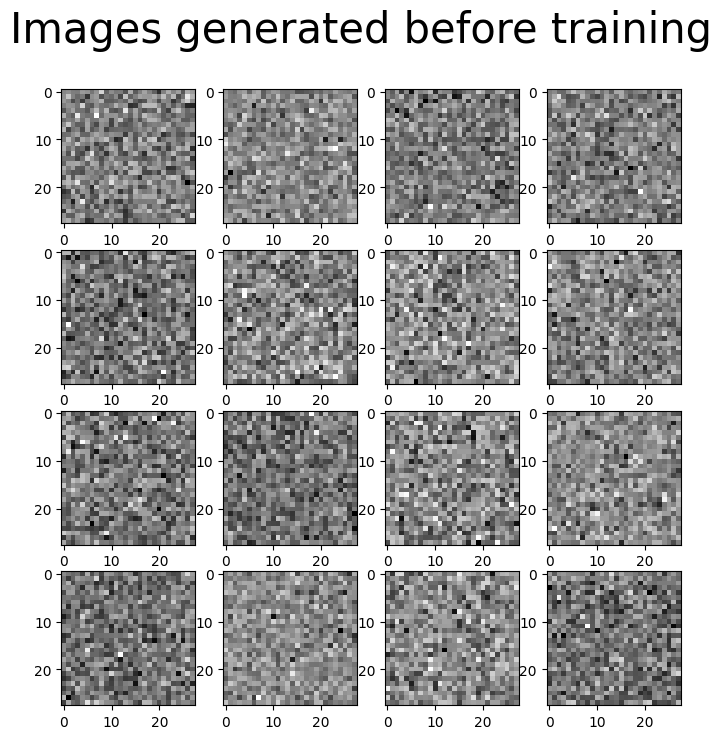

In [62]:
# Optionally, show the denoising (backward) process
generated = generate_new_images(ddpm, unet, gif_name="before_training.gif")
show_images(generated, "Images generated before training")

# Training loop

The training loop is fairly simple. With each batch of our dataset, we run the forward process on the batch. We use a different timesteps $t$ for each of the `N` images in our `(N, C, H, W)` batch tensor to guarantee more training stability. The added noise is a `(N, C, H, W)` tensor $\epsilon$.

Once we obtained the noisy images, we try to predict $\epsilon$ out of them with our network. We optimize with a simple Mean-Squared Error (MSE) loss.

In [63]:
def loss(model, ddpm, x0, t, eta):
    noisy_imgs = ddpm(x0, t, eta)
    # Getting model estimation of noise based on the images and the time-step
    eta_theta = model(noisy_imgs, t.reshape(len(x0), -1))

    # Optimizing the MSE between the noise plugged and the predicted noise
    return optax.l2_loss(eta_theta, eta).mean()

loss = eqx.filter_jit(loss) 

In [64]:
def training_loop(ddpm, model, loader, n_epochs, optim=optax.adam(0.01), display=False):

    n_steps = ddpm.n_steps
    best_loss = float("inf")

    @eqx.filter_jit
    def opt_step(opt_state, model, x0, t, eta):
        value, grads = eqx.filter_value_and_grad(loss)(model, ddpm, x0, t, eta)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value

    losses = []
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    
    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        print(epoch)
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].numpy()
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            # print(x0.shape)

            eta = np.random.randn(*x0.shape)
            t = np.random.choice(n_steps, (n))

            model, opt_state, value = opt_step(opt_state, model, x0, t, eta)
            # ddpm(x0,t)

            losses.append(value)
            epoch_loss += value * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(model, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        print(epoch_loss)
        # Storing the model 
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            best_model = model
            log_string += " --> Best model ever (stored)"

    return best_model, losses

In [65]:
x0 = np.random.randn(128,1,28,28)
t = np.random.choice(10, (128))
eta = np.random.randn(*x0.shape)
noisy_imgs = ddpm(x0, t, eta)

eta_theta = unet(noisy_imgs, t.reshape(len(x0), -1))
eta_theta
# optax.l2_loss(eta_theta, eta).mean()



Array([[[[-0.08291085, -0.08595447, -0.08205998, ..., -0.08356693,
          -0.08435479, -0.08839091],
         [-0.09469084, -0.10253406, -0.10419979, ..., -0.10084508,
          -0.10484155, -0.10984518],
         [-0.10028362, -0.107993  , -0.10303265, ..., -0.1030342 ,
          -0.10363078, -0.1086773 ],
         ...,
         [-0.09612331, -0.10557055, -0.10383313, ..., -0.10336769,
          -0.10220972, -0.10812868],
         [-0.09824495, -0.10723753, -0.10342158, ..., -0.10497703,
          -0.10561357, -0.10707461],
         [-0.09217946, -0.09574822, -0.09482024, ..., -0.09364856,
          -0.09396314, -0.1000855 ]]],


       [[[-0.08177094, -0.08575602, -0.08514675, ..., -0.0846551 ,
          -0.08445503, -0.08841597],
         [-0.09578474, -0.10297386, -0.1023423 , ..., -0.10154852,
          -0.10190784, -0.11025359],
         [-0.0994756 , -0.10872637, -0.10767628, ..., -0.10283452,
          -0.10374608, -0.10715127],
         ...,
         [-0.09710128, -0.107054

In [66]:
# Defining model
model, losses = training_loop(ddpm, unet, loader, n_epochs, optax.adam(0.01))

Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

0


Training progress:   4%|▍         | 1/25 [00:41<16:25, 41.05s/it]

0.1052087
1


Training progress:   8%|▊         | 2/25 [00:57<10:15, 26.77s/it]

0.02688305
2


Training progress:  12%|█▏        | 3/25 [01:14<08:09, 22.24s/it]

0.024019293
3


Training progress:  16%|█▌        | 4/25 [01:30<06:55, 19.79s/it]

0.022451408
4


Training progress:  20%|██        | 5/25 [01:46<06:10, 18.53s/it]

0.021555277
5


Training progress:  24%|██▍       | 6/25 [02:03<05:38, 17.79s/it]

0.24401206
6


Training progress:  28%|██▊       | 7/25 [02:19<05:11, 17.31s/it]

0.40998363
7


Training progress:  32%|███▏      | 8/25 [02:36<04:49, 17.03s/it]

0.044644933
8


Training progress:  36%|███▌      | 9/25 [02:52<04:28, 16.80s/it]

0.03372705
9


Training progress:  40%|████      | 10/25 [03:08<04:09, 16.63s/it]

0.030286241
10


Training progress:  44%|████▍     | 11/25 [03:24<03:50, 16.49s/it]

0.02914278
11


Training progress:  48%|████▊     | 12/25 [03:41<03:35, 16.54s/it]

0.028615674
12


Training progress:  52%|█████▏    | 13/25 [03:57<03:16, 16.41s/it]

0.027410295
13


Training progress:  56%|█████▌    | 14/25 [04:13<03:00, 16.39s/it]

205.5332
14


Training progress:  60%|██████    | 15/25 [04:30<02:43, 16.35s/it]

0.6659852
15


Training progress:  64%|██████▍   | 16/25 [04:46<02:26, 16.24s/it]

0.5206382
16


Training progress:  68%|██████▊   | 17/25 [05:02<02:10, 16.29s/it]

0.5150343
17


Training progress:  72%|███████▏  | 18/25 [05:19<01:54, 16.41s/it]

0.51187766
18


Training progress:  76%|███████▌  | 19/25 [05:35<01:38, 16.42s/it]

0.5096929
19


Training progress:  80%|████████  | 20/25 [05:52<01:22, 16.51s/it]

0.5085812
20


Training progress:  84%|████████▍ | 21/25 [06:08<01:05, 16.29s/it]

0.50723577
21


Training progress:  88%|████████▊ | 22/25 [06:24<00:48, 16.27s/it]

0.50617254
22


Training progress:  92%|█████████▏| 23/25 [06:41<00:32, 16.37s/it]

0.5054237
23


Training progress:  96%|█████████▌| 24/25 [06:57<00:16, 16.25s/it]

0.5044809
24


Training progress: 100%|██████████| 25/25 [07:13<00:00, 17.33s/it]

0.50391144


11725

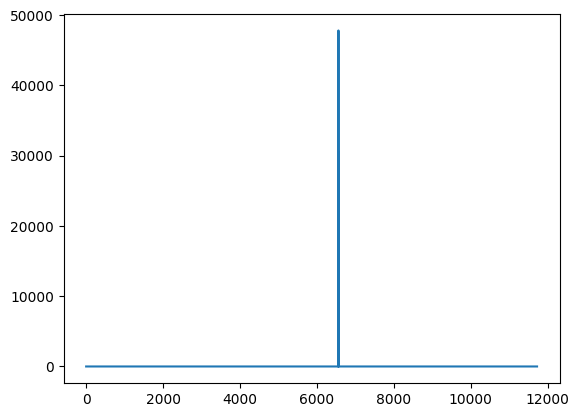

In [67]:
plt.plot(losses)
len(losses)

In [68]:
ddpm.betas

Array([9.99999975e-05, 1.19919918e-04, 1.39839831e-04, 1.59759758e-04,
       1.79679671e-04, 1.99599599e-04, 2.19519512e-04, 2.39439425e-04,
       2.59359367e-04, 2.79279251e-04, 2.99199193e-04, 3.19119106e-04,
       3.39039019e-04, 3.58958961e-04, 3.78878874e-04, 3.98798788e-04,
       4.18718701e-04, 4.38638643e-04, 4.58558527e-04, 4.78478469e-04,
       4.98398382e-04, 5.18318266e-04, 5.38238208e-04, 5.58158150e-04,
       5.78078092e-04, 5.97997976e-04, 6.17917860e-04, 6.37837802e-04,
       6.57757744e-04, 6.77677628e-04, 6.97597570e-04, 7.17517512e-04,
       7.37437396e-04, 7.57357338e-04, 7.77277281e-04, 7.97197165e-04,
       8.17117048e-04, 8.37037049e-04, 8.56956933e-04, 8.76876817e-04,
       8.96796759e-04, 9.16716701e-04, 9.36636585e-04, 9.56556527e-04,
       9.76476469e-04, 9.96396411e-04, 1.01631624e-03, 1.03623618e-03,
       1.05615612e-03, 1.07607606e-03, 1.09599601e-03, 1.11591583e-03,
       1.13583577e-03, 1.15575572e-03, 1.17567554e-03, 1.19559560e-03,
      

In [69]:
model

MyUNet_Jax(
  time_embed=Embedding(
    num_embeddings=1000,
    embedding_size=100,
    weight=f32[1000,100]
  ),
  te1=Sequential(
    layers=(
      Linear(
        weight=f32[1,100],
        bias=f32[1],
        in_features=100,
        out_features=1,
        use_bias=True
      ),
      Lambda(fn=<wrapped function silu>),
      Linear(
        weight=f32[1,1],
        bias=f32[1],
        in_features=1,
        out_features=1,
        use_bias=True
      )
    )
  ),
  te2=Sequential(
    layers=(
      Linear(
        weight=f32[10,100],
        bias=f32[10],
        in_features=100,
        out_features=10,
        use_bias=True
      ),
      Lambda(fn=<wrapped function silu>),
      Linear(
        weight=f32[10,10],
        bias=f32[10],
        in_features=10,
        out_features=10,
        use_bias=True
      )
    )
  ),
  te3=Sequential(
    layers=(
      Linear(
        weight=f32[20,100],
        bias=f32[20],
        in_features=100,
        out_features=20,
      

In [70]:
# # Training
# store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"
# if not no_train:
#     training_loop(ddpm, loader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

# Testing the trained model

Time to check how well our model does. We re-store the best performing model according to our training loss and set it to evaluation mode. Finally, we display a batch of generated images and the relative obtained and nice GIF.

In [71]:
# Loading the trained model
# best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
# best_model.load_state_dict(torch.load(store_path, map_location=device))
# best_model.eval()
# print("Model loaded")

In [72]:
best_model = model

In [73]:
# n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
# saved_model = MyDDPM_Jax(MyUNet_Jax(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta)
# model_loaded = eqx.tree_deserialise_leaves("trained_mnist_jax.eqx", saved_model)

Generating new images


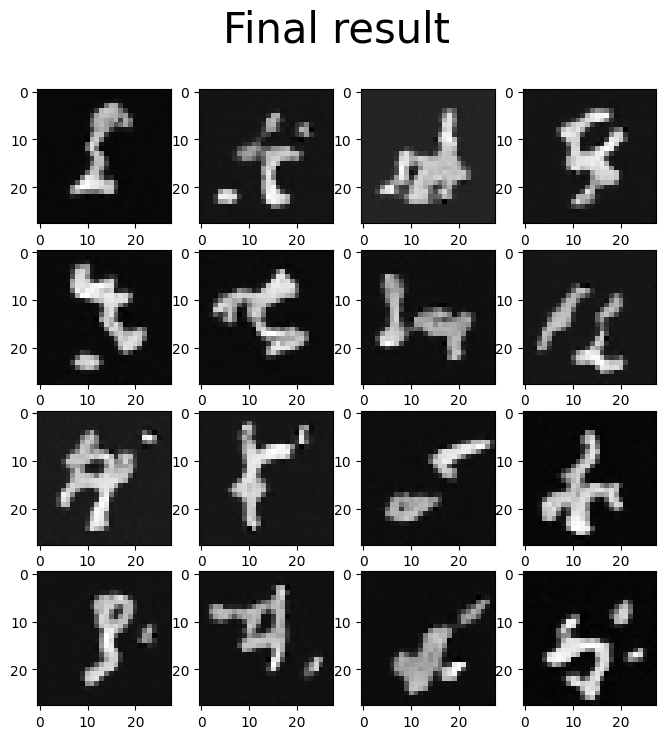

In [74]:
print("Generating new images")
generated = generate_new_images(ddpm,
        best_model,
        n_samples=16,
        gif_name="fashion.gif" if fashion else "mnist.gif"
    )
show_images(generated, "Final result")

# Visualizing the diffusion

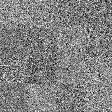

In [75]:
from IPython.display import Image

Image(open('fashion.gif' if fashion else 'mnist.gif','rb').read())


## Papers
- **Denoising Diffusion Implicit Models** by Song et. al. (https://arxiv.org/abs/2010.02502);
- **Improved Denoising Diffusion Probabilistic Models** by Nichol et. al. (https://arxiv.org/abs/2102.09672);
- **Hierarchical Text-Conditional Image Generation with CLIP Latents** by Ramesh et. al. (https://arxiv.org/abs/2204.06125);
- **Photorealistic Text-to-Image Diffusion Models with Deep Language Understanding** by Saharia et. al. (https://arxiv.org/abs/2205.11487);
